In [1]:
# imports
import cv2
import os
import numpy as np
from IPython.display import display, Javascript, Image
from base64 import b64decode, b64encode
import PIL
import io
import html
import time
from statistics import mean
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch import optim
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torchvision.transforms.functional  import InterpolationMode
import torchvision
from torchsummary import summary
from datetime import datetime
import threading

In [3]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118


Looking in indexes: https://download.pytorch.org/whl/cu118



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
torch.cuda.is_available()


True

In [3]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Capture imgs from Webcam locally

### Dataset definition

In [38]:
BATCH_SIZE = 64

In [39]:
# Define transform without normalization
transform = transforms.Compose([
    transforms.ToTensor()
])

# Load the dataset
train_dataset = ImageFolder(root='your_dataset_directory/train', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)


In [40]:
def calculate_mean_std(loader):
    mean = 0.0
    std = 0.0
    total_images_count = 0

    for images, _ in loader:
        # Reshape the images to [BATCH_SIZE, 3, -1] and compute mean and std along the channel axis
        images = images.view(images.size(0), images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_images_count += images.size(0)

    mean /= total_images_count
    std /= total_images_count

    return mean, std

# Compute mean and std
mean, std = calculate_mean_std(train_loader)

print("Data mean: ", mean)
print("Data std: ", std)


Data mean:  tensor([0.5115, 0.5178, 0.5166])
Data std:  tensor([0.2187, 0.2269, 0.2287])


In [41]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.01, contrast=0.01, saturation=0.01, hue=0.01),
    transforms.ToTensor(),
    transforms.Normalize(mean.tolist(), std.tolist())
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean.tolist(), std.tolist())
])

train_dataset = ImageFolder(root='your_dataset_directory/train', transform=train_transform)
test_dataset = ImageFolder(root='your_dataset_directory/test', transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# print the length of your train and validation sets
print(f"Train dataset length: {len(train_dataset)}")
print(f"Test dataset length: {len(test_dataset)}")


Train dataset length: 2850
Test dataset length: 3000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


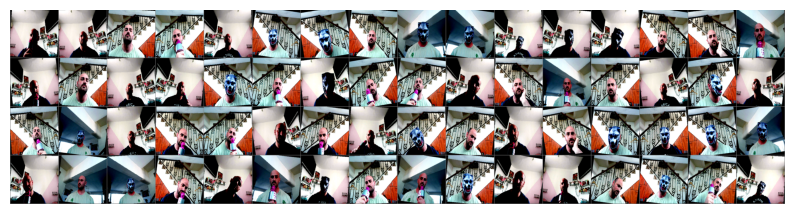

1 0 0 1 0 2 2 0 2 2 2 2 2 0 0 1 1 0 0 1 2 1 2 1 1 0 0 1 0 0 2 0 1 2 0 1 1 0 1 1 2 0 1 0 2 2 2 2 1 0 2 1 0 1 2 1 1 2 0 1 0 2 1 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


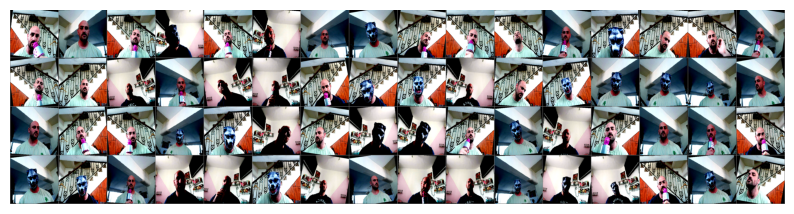

1 0 1 2 1 1 0 2 1 1 0 1 2 0 0 1 1 0 0 1 0 1 1 2 2 0 0 2 2 2 2 0 0 1 1 2 2 0 0 2 2 1 2 0 1 0 1 1 2 2 1 0 1 2 0 0 1 0 2 2 2 1 2 0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


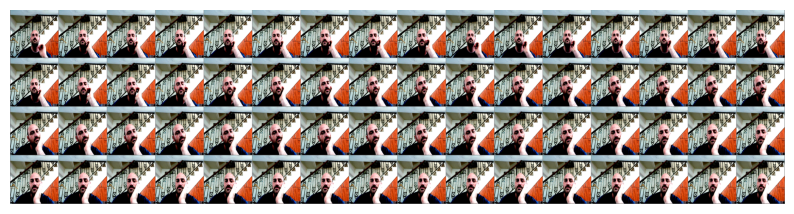

0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


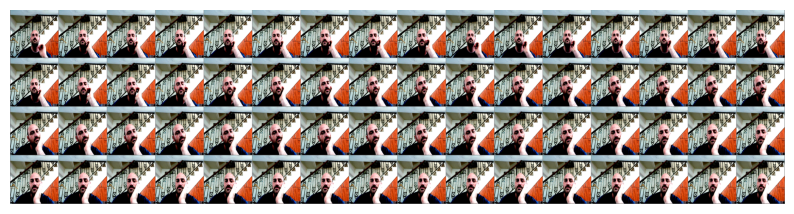

0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
Batch shape: torch.Size([64, 3, 256, 256])
Min pixel value: -2.3382768630981445
Max pixel value: 2.2334136962890625
Average pixel value: -0.042104970663785934


In [42]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision

def imshow(img, figsize=(10, 10)):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    npimg = np.transpose(npimg, (1, 2, 0))
    plt.figure(figsize=figsize)
    plt.imshow(npimg)
    plt.axis('off')  # Hide axes
    plt.show()

nrow = 16 # Numbers of imgs in a row

# Get a batch of training data
for i in range(2):
    dataiter = iter(train_loader)
    images, labels = next(dataiter)
    grid_img = torchvision.utils.make_grid(images, nrow=nrow)
    imshow(grid_img, figsize=(10, 10))
    print(' '.join(f'{label}' for label in labels))

for i in range(2):
    # Plot a few validation batches with their labels
    dataiter = iter(test_loader)
    images, labels = next(dataiter)
    grid_img = torchvision.utils.make_grid(images, nrow=nrow)
    imshow(grid_img, figsize=(10, 10))
    print(' '.join(f'{label}' for label in labels))

# Print the shape of a single batch of images, and their min, max, and average pixel value
print(f"Batch shape: {images.shape}")
print(f"Min pixel value: {torch.min(images)}")
print(f"Max pixel value: {torch.max(images)}")
print(f"Average pixel value: {torch.mean(images)}")



#Training#

In [43]:

class liveClassifier(nn.Module):
    def __init__(self):
        super(liveClassifier, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        # Conv output = [(256+2x1-3)\1] + 1 = 256
        # Max pooling = (256\2) = 128
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2))
        # Conv output = [(128+2x0-3)\1] + 1 = 126
        # Max pooling = (126\2) = 63
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2))
        # Conv output = [(63+2x0-3)\1] + 1 = 61
        # Max pooling = (61\2) = 30
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2))
        # Conv output = [(30+2x0-3)\1] + 1 = 28
        # Max pooling = (28\2) = 14

        self.fc1 = nn.Linear(256 * 14 * 14, 1024)
        self.drop = nn.Dropout2d(0.5)
        self.fc2 = nn.Linear(1024, 512)
        self.drop = nn.Dropout2d(0.5)
        self.fc3 = nn.Linear(512, 128)
        self.fc4 = nn.Linear(128, 3)


    def forward(self, input):
        out = self.layer1(input)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.drop(out)
        out = self.fc3(out)
        out = self.fc4(out)
        return out


In [61]:

# Define your own video width and height
width = 256
height = 256

# Number of images to save per class
num_of_images_to_save = 200

# Directory paths
dataset_dir = 'your_dataset_directory'
text_for_classes = ['Nothing', 'Singer', 'Wolf']
num_classes = len(text_for_classes)

def convert_frame(frame):
    frame = cv2.resize(frame, (width, height))
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    # plt.imshow(frame)
    # plt.axis('off')  # Turn off axis labels
    # plt.show()
    return frame

def capture_images(save_path, class_index):
    cap = cv2.VideoCapture(0)
    saved_frames = 0
    frame_num = 0
    file_names = []
    frames = []

    while saved_frames < num_of_images_to_save:
        ret, frame = cap.read()
        if not ret:
            break

        frame_num += 1
        converted_frame = convert_frame(frame)

        file_name = os.path.join(save_path, f"{class_index}", f"{datetime.now().strftime('%m_%d_%Y_%H_%M_%S')}_{frame_num}.jpg")
        file_names.append(file_name)
        frames.append(converted_frame)

        saved_frames += 1
        cv2.imshow('Capturing Images', frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

    print('Saving to disk...')
    for i, f in enumerate(file_names):
        cv2.imwrite(f, cv2.cvtColor(frames[i], cv2.COLOR_BGR2RGB))

# Create directories for each class
for i in range(num_classes):
    os.makedirs(os.path.join(dataset_dir, 'train', str(i)), exist_ok=True)
    os.makedirs(os.path.join(dataset_dir, 'test', str(i)), exist_ok=True)

def grab_dataset(save_path):
    for i in range(num_classes):
        input(f'Press Enter to capture class {text_for_classes[i]}...')
        capture_images(save_path, i)

# Capture training dataset
grab_dataset(os.path.join(dataset_dir, 'train'))

# Capture testing dataset
grab_dataset(os.path.join(dataset_dir, 'test'))


Saving to disk...
Saving to disk...
Saving to disk...
Saving to disk...
Saving to disk...
Saving to disk...


In [44]:
# Create an instance of your model, and print its summary

device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
print(device)
model = liveClassifier().to(device)

# Place your code here (5): print summary using summary(model,(aa, bb, bb ))
summary(model, (3, 256, 256))

cuda:0
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             896
              ReLU-2         [-1, 32, 256, 256]               0
         MaxPool2d-3         [-1, 32, 128, 128]               0
            Conv2d-4         [-1, 64, 126, 126]          18,496
              ReLU-5         [-1, 64, 126, 126]               0
         MaxPool2d-6           [-1, 64, 63, 63]               0
            Conv2d-7          [-1, 128, 61, 61]          73,856
              ReLU-8          [-1, 128, 61, 61]               0
         MaxPool2d-9          [-1, 128, 30, 30]               0
           Conv2d-10          [-1, 256, 28, 28]         295,168
             ReLU-11          [-1, 256, 28, 28]               0
        MaxPool2d-12          [-1, 256, 14, 14]               0
           Linear-13                 [-1, 1024]      51,381,248
        Dropout2d-14            

In [46]:

# Place your code here (6): Define your loss criterion, and optimizer (e.g criterion = nn.CrossEntropyLoss(), optimizer = optimizer = torch.optim.SGD(model.parameters(), lr=0.002, momentum = 0.9)

# optimizer = torch.optim.SGD(model.parameters(), lr=0.002, momentum=0.9)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss() # Does have LogSoftmax + NLLLoss (= Softmax)


In [47]:
num_epochs = 200
patience = 7
counter = 0
best_score = None
early_stop = False
path='best_model_checkpoint_3.pt'


In [33]:
train_losses, val_losses = [], []
train_accuracy, val_accuracy = [], []

# Place your code here (7): train loop

for epoch in range(num_epochs):

    #Place your code here (7.1): Train (don't forget to call model.train())
    # Train phase
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    avg_train_accuracy = correct_train / total_train
    train_accuracy.append(avg_train_accuracy)

    #Place your code here (7.2): Evaluate (don't forget to call model.eval())
    # Evaluate phase
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(test_loader)
    val_losses.append(avg_val_loss)
    avg_val_accuracy = correct_val / total_val
    val_accuracy.append(avg_val_accuracy)

    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, Train Accuracy: {avg_train_accuracy * 100:.2f}%, Validation Accuracy: {avg_val_accuracy * 100:.2f}%')

    # Early Stopping Check and Model Saving
    if best_score is None:
        best_score = avg_val_loss
        torch.save(model.state_dict(), path)

    elif avg_val_loss < best_score:
        print(f'Validation loss improved ({best_score:.4f} --> {avg_val_loss:.4f}). Saving model...')
        best_score = avg_val_loss
        torch.save(model.state_dict(), path)
        counter = 0

    else:
        counter += 1
        print(f'Validation loss did not improve from {best_score:.4f}. EarlyStopping counter: {counter} out of {patience}')
        if counter >= patience:
            early_stop = True

    if early_stop:
        print(f"Early stopping triggered. Training was stopped at EPOCH: {epoch + 1 - counter}")
        print(f"Best model with the Validation Loss of: {best_score:.4f}, saved to '{path}'")
        break



C:\Users\agran\anaconda3\Lib\site-packages\torch\nn\functional.py:1374: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch [1/200], Train Loss: 0.7713, Validation Loss: 0.2843, Train Accuracy: 60.25%, Validation Accuracy: 87.60%
Epoch [2/200], Train Loss: 0.1580, Validation Loss: 0.1283, Train Accuracy: 93.44%, Validation Accuracy: 92.30%
Validation loss improved (0.2843 --> 0.1283). Saving model...
Epoch [3/200], Train Loss: 0.0504, Validation Loss: 0.0639, Train Accuracy: 98.04%, Validation Accuracy: 98.47%
Validation loss improved (0.1283 --> 0.0639). Saving model...
Epoch [4/200], Train Loss: 0.0197, Validation Loss: 0.1659, Train Accuracy: 99.40%, Validation Accuracy: 92.83%
Validation loss did not improve from 0.0639. EarlyStopping counter: 1 out of 7
Epoch [5/200], Train Loss: 0.0158, Validation Loss: 0.0552, Train Accuracy: 99.65%, Validation Accuracy: 98.07%
Validation loss improved (0.0639 --> 0.0552). Saving model...
Epoch [6/200], Train Loss: 0.0027, Validation Loss: 0.0696, Train Accuracy: 99.96%, Validation Accuracy: 98.40%
Validation loss did not improve from 0.0552. EarlyStopping coun

In [48]:
# Load the best model and print its performance
best_model = liveClassifier().to(device)
best_model.load_state_dict(torch.load("best_model_checkpoint_2.pt"))
best_model.eval()

val_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = best_model(inputs)
        loss = criterion(outputs, labels)
        val_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

val_loss = val_loss / len(test_loader.dataset)
val_accuracy = correct / total

print(f'Best Model Performance: Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')


Best Model Performance: Val Loss: 0.3342, Val Accuracy: 0.9553


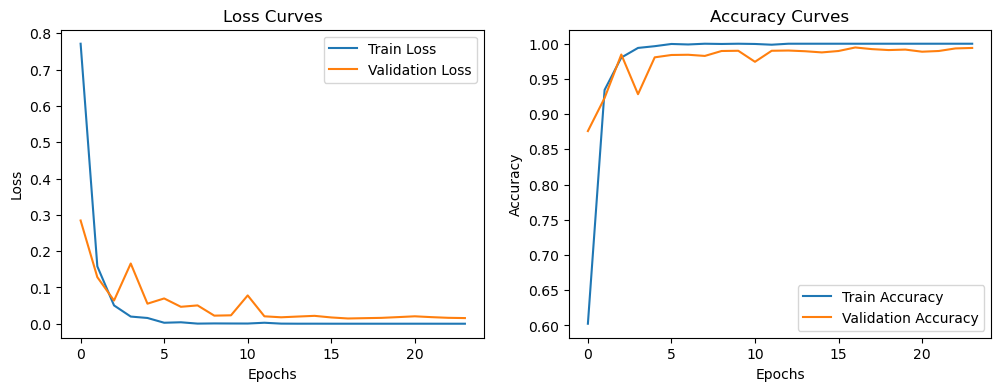

In [34]:
#Place your code here (7.6): plot loss and accuracy curves (Train + evaluation)
# Plot loss and accuracy curves
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curves')

plt.subplot(1, 2, 2)
plt.plot(train_accuracy , label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curves')

plt.show()

## Inference

In [49]:
model = liveClassifier()
model.load_state_dict(torch.load('best_model_checkpoint_2.pt'))  # Load your trained model


<All keys matched successfully>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


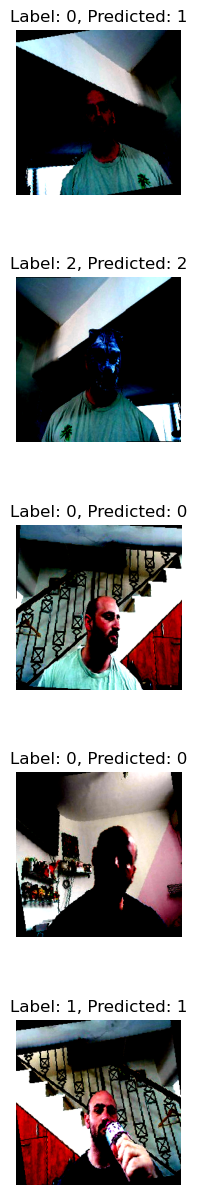

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


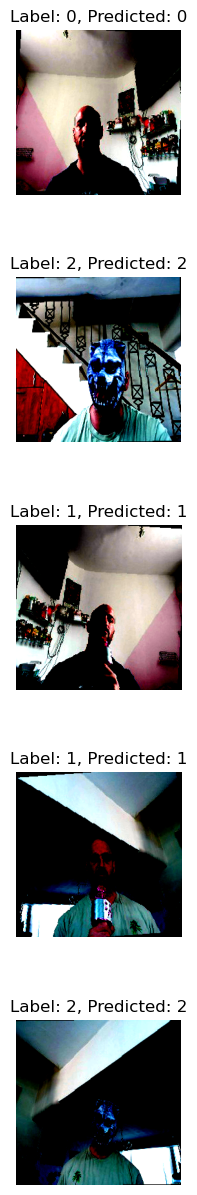

In [50]:
model.eval()
new_dataloader = DataLoader(train_loader.dataset, batch_size=5, shuffle=True)

# Iterate over some batches
for batch_idx, (images, labels) in enumerate(new_dataloader):
    if batch_idx >= 2:  # Plot only the first 5 batches
        break

    # Move data to GPU
    # images = images.to('cuda')
    # labels = labels.to('cuda')

    # Make predictions
    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

    # Plot the images with labels and predictions
    plt.figure(figsize=(15, 15))  # Set the figure size
    plt.subplots_adjust(hspace=0.5)  # Add space between subplots
    # Plot the images with labels and predictions
    for i in range(images.size(0)):  # Iterate over batch size
        plt.subplot(images.size(0), 1, i+1)  # Changed subplot parameters
        plt.axis('off')
        plt.imshow(images[i].permute(1, 2, 0).cpu().numpy())  # Move image back to CPU for plotting
        plt.title(f'Label: {labels[i].item()}, Predicted: {predicted[i].item()}')  # Use item() to get scalar value from tensor
    plt.show()


In [54]:
# Place your code here (9): Run live inference, plot classification on the video using bbox_array = cv2.putText(img=bbox_array, text=pred_class_name, org=(x, y), fontFace=cv2.FONT_HERSHEY_TRIPLEX, fontScale=0.6, color=(200, 200, 200, 255),thickness=1)
# Also save frames with classification plotted on it to video file (download it for submition)

# Define the transform for the video frames
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Define class names (adjust based on your dataset)
class_names = ['Nothing', 'Noa Kirel','Wolf']

# Initialize video capture (0 for webcam or provide video file path)
cap = cv2.VideoCapture(0)

# Define the codec and create VideoWriter object to save the video
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('output.avi', fourcc, 20.0, (640, 480))

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    frame = cv2.flip(frame, 1)

    # Preprocess the frame
    img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (256, 256))
    img = transform(img).unsqueeze(0)

    with torch.no_grad():
        outputs = model(img)
        probabilities = F.softmax(outputs, dim=1)
        confidence, predicted = torch.max(probabilities, 1)
        pred_class_name = class_names[predicted.item()]
        pred_confidence = confidence.item()

    # Plot classification result on the frame
    x, y = 50, 50  # Position to display the text
    # bbox_array = cv2.putText(frame, f"{pred_class_name}: {pred_confidence:.2f}", (x, y),
    #                          cv2.FONT_HERSHEY_TRIPLEX, 1, (255, 255, 255, 0), 1)
    bbox_array = cv2.putText(frame, f"{pred_class_name}", (x, y),
                             cv2.FONT_HERSHEY_TRIPLEX, 1, (255, 255, 255, 0), 1)
    bbox_array_1 = cv2.putText(frame, "Press 'q' to Exit", (400, 50),
                               cv2.FONT_HERSHEY_TRIPLEX, 0.6, (255, 255, 255, 0), 1)

    # Display the frame
    cv2.imshow('Frame', frame)

    # Write the frame with the classification to the output video
    out.write(frame)

    # Break the loop on 'q' key press
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the video capture and writer objects
cap.release()
out.release()
cv2.destroyAllWindows()




**I hope you had fun (-:**

Good luck!

Lahav